In [1]:
#Using Chalk
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def load_and_preprocess_images(chalkwater_dir, clearwater_dir, num_images=499):
    chalkwater_images = os.listdir(chalkwater_dir)[:num_images]
    clearwater_images = os.listdir(clearwater_dir)[:num_images]
    processed_images = []

    for chalk_img_name, clear_img_name in zip(chalkwater_images, clearwater_images):
        chalk_img_path = os.path.join(chalkwater_dir, chalk_img_name)
        clear_img_path = os.path.join(clearwater_dir, clear_img_name)
        
        chalk_img = cv2.imread(chalk_img_path)
        clear_img = cv2.imread(clear_img_path)
        
        if chalk_img is not None and clear_img is not None:
            diff_img = chalk_img.astype('float32') - clear_img.astype('float32')
            normalized_img = diff_img / 255.0
            processed_images.append(normalized_img)

    return np.array(processed_images)

In [2]:

csv_file_path = '/Users/tarunangalla/Desktop/chalkdatappm.csv' 
ppm_values = pd.read_csv(csv_file_path)[' PPM  values'].values  


ppm_min = ppm_values.min()
ppm_max = ppm_values.max()
normalized_ppm = (ppm_values - ppm_min) / (ppm_max - ppm_min)

chalkwater_dir = '/Users/tarunangalla/Desktop/chalkdata'
clearwater_dir = '/Users/tarunangalla/Desktop/clearwater'

images = load_and_preprocess_images(chalkwater_dir, clearwater_dir, num_images=500)
print("Total Images Loaded:", len(images))


normalized_ppm = normalized_ppm[:len(images)]

X_train, X_test, y_train, y_test = train_test_split(images, normalized_ppm, test_size=0.1, random_state=42)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=10, validation_split=0.1)

test_loss = model.evaluate(X_test, y_test)
print('Test Loss for chalk:', test_loss)


Total Images Loaded: 500


2023-12-14 07:37:37.345920: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2023-12-14 07:37:37.345963: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2023-12-14 07:37:37.345977: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2023-12-14 07:37:37.346094: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-14 07:37:37.346949: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2023-12-14 07:37:47.831681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 0.0172

2023-12-14 07:38:57.721217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 73s 5s/step - loss: 0.0172 - val_loss: 0.0253
Epoch 2/10
13/13 [==============================] - 817s 68s/step - loss: 0.0101 - val_loss: 0.0180
Epoch 3/10
13/13 [==============================] - 61s 5s/step - loss: 0.0101 - val_loss: 0.0211
Epoch 4/10
13/13 [==============================] - 64s 5s/step - loss: 0.0098 - val_loss: 0.0234
Epoch 5/10
13/13 [==============================] - 146s 12s/step - loss: 0.0098 - val_loss: 0.0225
Epoch 6/10
13/13 [==============================] - 65s 5s/step - loss: 0.0098 - val_loss: 0.0206
Epoch 7/10
13/13 [==============================] - 319s 26s/step - loss: 0.0098 - val_loss: 0.0225
Epoch 8/10
13/13 [==============================] - 66s 5s/step - loss: 0.0098 - val_loss: 0.0224
Epoch 9/10
13/13 [==============================] - 60s 5s/step - loss: 0.0098 - val_loss: 0.0213
Epoch 10/10
2/2 [==============================] - 1s 330ms/step - loss: 0.0138
Test Loss: 0.013788397423923016


In [3]:
def mean_absolute_error(actual, predicted):
    return np.mean(np.abs(actual - predicted))

def mean_squared_error(actual, predicted):
    return np.mean(np.square(actual - predicted))

def root_mean_squared_error(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))


predictions = model.predict(X_test)

mae_score = mean_absolute_error(y_test, predictions)
mse_score = mean_squared_error(y_test, predictions)
rmse_score = root_mean_squared_error(y_test, predictions)

print('Mean Absolute Error:', mae_score)
print('Mean Squared Error:', mse_score)
print('Root Mean Squared Error:', rmse_score)

2023-12-14 08:06:42.201445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 432ms/step
Mean Absolute Error: 0.08945775567584323
Mean Squared Error: 0.012397454174602343
Root Mean Squared Error: 0.1113438555763287


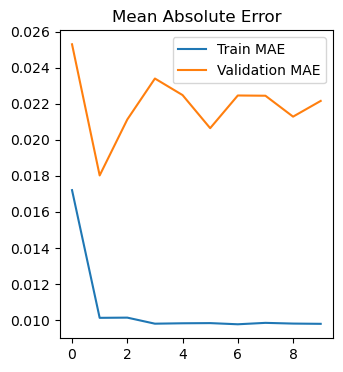

In [5]:
import matplotlib.pyplot as plt

rmse_train = np.sqrt(history.history['loss'])
rmse_val = np.sqrt(history.history['val_loss'])

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train MAE')
plt.plot(history.history['val_loss'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.legend()
plt.show()



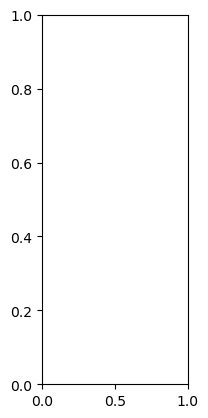

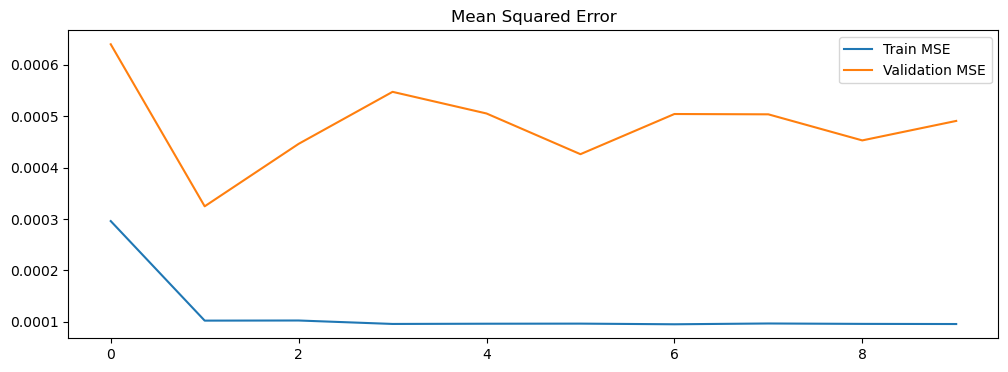

In [14]:
plt.subplot(1, 3, 1)
plt.figure(figsize=(12, 4))
plt.plot(np.square(history.history['loss']), label='Train MSE')
plt.plot(np.square(history.history['val_loss']), label='Validation MSE')
plt.title('Mean Squared Error')
plt.legend()
plt.show()

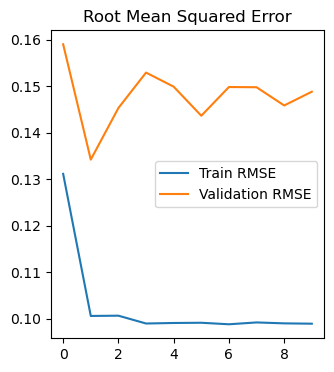

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(rmse_train, label='Train RMSE')
plt.plot(rmse_val, label='Validation RMSE')
plt.title('Root Mean Squared Error')
plt.legend()

plt.show()